In [2]:
#Choose the tensorflow-v2.2.0-gpu kernel from the dropdown menu!
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,ZeroPadding2D, BatchNormalization, Activation, Layer, ReLU, LeakyReLU,Conv2D,AveragePooling2D,UpSampling2D,Reshape,Flatten
from tensorflow.keras import backend as K

In [3]:
# Must be TF version 2
print(tf.__version__)

2.2.0


In [4]:
from func import load_model, save_model

## Load dataset

In [5]:
# You should already have run
# python create_datasets.py --bkg_file /ocean/projects/cis210053p/jngadiub/background_for_training.h5 --output_bkg_name 'BKG' --signals_files '/ocean/projects/cis210053p/jngadiub/Ato4l_lepFilter_13TeV.h5' --output_signal_names 'Ato4l_lepFilter_13TeV' --events=1000000
filename = '/global/cscratch1/sd/vmikuni/ADC/BKG_dataset.h5'

In [6]:
# load background training data
with h5py.File(filename, 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

print(X_train.shape)
X_train = np.reshape(X_train, (-1, 19,3,1))
X_test = np.reshape(X_test, (-1, 19,3,1))
X_val = np.reshape(X_val, (-1, 19,3,1))

print(X_train.shape)

(640000, 57)
(640000, 19, 3, 1)


## Define CNN architecture

In [7]:
image_shape = (19,3,1)
latent_dimension = 8
num_nodes=[16,8]

In [8]:
#encoder
input_encoder = Input(shape=(image_shape))
x = Conv2D(10, kernel_size=(3, 3),
         use_bias=False, data_format='channels_last', padding='same')(input_encoder)
x = AveragePooling2D(pool_size = (2, 1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Flatten()(x)
x = Dense(latent_dimension)(x)
enc = Activation('relu')(x)
encoder = Model(inputs=input_encoder, outputs=enc)
#decoder
x = Dense(270)(enc)
x = Activation('relu')(x)
x = Reshape((9,3,10))(x)
x = UpSampling2D((2, 1))(x)
x = ZeroPadding2D(((1, 0),(0,0)))(x)
x = Conv2D(1, kernel_size=(3,3), use_bias=False, data_format='channels_last', padding='same')(x)
x = BatchNormalization()(x)
dec = Activation('relu')(x)

autoencoder = Model(inputs=input_encoder, outputs=dec)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19, 3, 1)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 19, 3, 10)         90        
_________________________________________________________________
average_pooling2d (AveragePo (None, 9, 3, 10)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 3, 10)          40        
_________________________________________________________________
activation (Activation)      (None, 9, 3, 10)          0         
_________________________________________________________________
flatten (Flatten)            (None, 270)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 2168

In [9]:
autoencoder.compile(optimizer = keras.optimizers.Adam(), loss='mse')

## Train model

In [10]:
EPOCHS = 10
BATCH_SIZE = 1024

In [11]:
history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val))

Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 63.9496 - val_loss: 55.2107
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 51.9880 - val_loss: 45.9986
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 43.2894 - val_loss: 38.4884
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 35.9381 - val_loss: 31.7916
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 29.5737 - val_loss: 26.1075
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 24.0057 - val_loss: 20.7708
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 19.1478 - val_loss: 16.3680
Epoch 8/10
625/625 [==============================] - 2s 2ms/step - loss: 14.9454 - val_loss: 12.6476
Epoch 9/10
625/625 [==============================] - 2s 3ms/step - loss: 11.3771 - val_loss: 9.3703
Epoch 10/10
625/625 [==============================] - 2s 3ms/step - loss: 8.3969 -

In [12]:
model_name = 'CNN_AE'
model_directory = 'CNNS/'
if not os.path.exists(model_directory+model_name):
    os.makedirs(model_directory+model_name)
save_model(model_directory+model_name, autoencoder)

## Prediction - background

In [13]:
bkg_prediction = autoencoder.predict(X_test)

## Prediction - signals

In [14]:
# add correct signal labels
signal_labels = ['Data']

In [15]:
# add correct path to signal files
signals_file = ['/global/cscratch1/sd/vmikuni/ADC/Ato4l_lepFilter_13TeV_dataset.h5']

In [16]:
# read signal data
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file[label])
    signal_data.append(test_data)

In [17]:
signal_results = []

for i, label in enumerate(signal_labels):
    signal_prediction = autoencoder.predict(signal_data[i].reshape(-1,19,3,1))
    signal_results.append([label, signal_data[i], signal_prediction]) # save [label, true, prediction] for signal

## Save results

In [18]:
save_file = 'cnnae_results'

In [19]:
with h5py.File(save_file, 'w') as file:
    file.create_dataset('BKG_input', data=X_test)
    file.create_dataset('BKG_predicted', data = bkg_prediction)
    for i, sig in enumerate(signal_results):
        file.create_dataset('%s_input' %sig[0], data=sig[1])
        file.create_dataset('%s_predicted' %sig[0], data=sig[2])

## Evaluate results

1. Plot loss distribution after prediction (check loss value for signals)
2. Plot ROC curves - how good is anomaly detection for chosen FPR threshold

# 1.

In [26]:
import importlib
import func
from func import mse_loss
importlib.reload(func)

<module 'func' from '/global/u2/v/vmikuni/ADC2021-examplecode/func.py'>

In [1]:
# compute loss value (true, predicted)
total_loss = []
shape=(-1,X_test.shape[1]*X_test.shape[2])
total_loss.append(mse_loss(X_test.reshape(shape),bkg_prediction.reshape(shape)))
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss(signal_X,(signal_results[i][2].reshape(shape))))

NameError: name 'X_test' is not defined

In [2]:
bin_size=100

plt.hist(total_loss[0], bins=bin_size, label="Background", density = True, histtype='step', fill=False, linewidth=1.5)
plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    plt.hist(total_loss[i+1], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

NameError: name 'plt' is not defined

# 2.

In [30]:
from sklearn.metrics import roc_curve, auc

In [31]:
labels = np.concatenate([['Background'], np.array(signal_labels)])

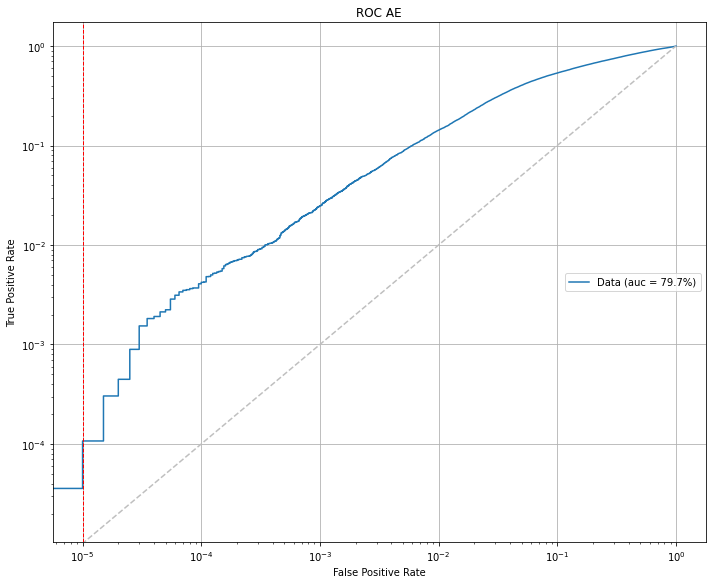

In [32]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)
    
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE")
plt.show()